In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats

sns.set_style('whitegrid')
color_palette = sns.color_palette("muted")
sns.set_palette(color_palette)

def create_fig(figsize=(8,4.5), dpi=100):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    return fig

In [2]:
df = pd.read_csv("./data/train.csv")

# Dataset details, clean null

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


> RangeIndex: 891 = มี 891 row

>  `Age          714 non-null` ... จะเห็นว่า Age บาง row มีค่าเป็น nan

## count null

isnull / isna ต่างกันยังไง?

> Pandas provides isnull(), isna() functions to detect missing values. Both of them do the same thing.

[ref](https://towardsdatascience.com/handling-missing-values-with-pandas-b876bf6f008f)

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Head

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Describe

In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


> คนรอด 38%

# 
## Fill na Age

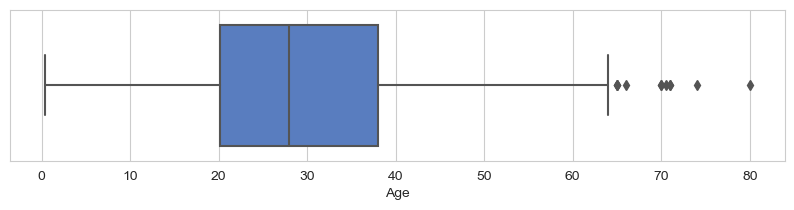

In [8]:
create_fig(figsize=(10, 2), dpi=100)
sns.boxplot(df['Age'])
plt.show()

> ไม่ค่อยมี outlier

In [9]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

> fill ด้วย mean found down

In [10]:
df['Age'].fillna(np.floor(df['Age'].mean()), inplace=True)

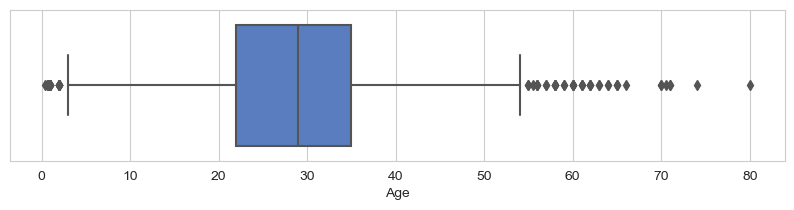

In [11]:
create_fig(figsize=(10, 2), dpi=100)
sns.boxplot(df['Age'])
plt.show()

In [12]:
df['Age'].describe()

count    891.000000
mean      29.560236
std       13.005010
min        0.420000
25%       22.000000
50%       29.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

# 
## Fill na Embarked
> Embarked เป็น categorial ... fill ด้วยค่าที่เจอบ่อยที่สุด

จะเติมด้วยค่าที่เจอบ่อยสุด ?

มีไอเดียจาก [A Statistical Analysis & ML workflow of Titanic](https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic/notebook)
ในการหาค่าที่ควรจะเติม

In [13]:
df[df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [14]:
df['Embarked'].value_counts().sort_values()

Q     77
C    168
S    644
Name: Embarked, dtype: int64

In [15]:
df['Embarked'].value_counts().sort_values().index[2]

'S'

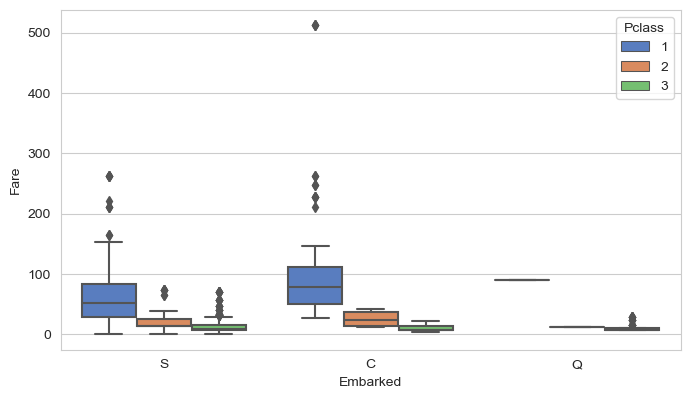

In [16]:
create_fig()
sns.boxplot(x='Embarked', y='Fare', data=df, hue='Pclass')
plt.show()

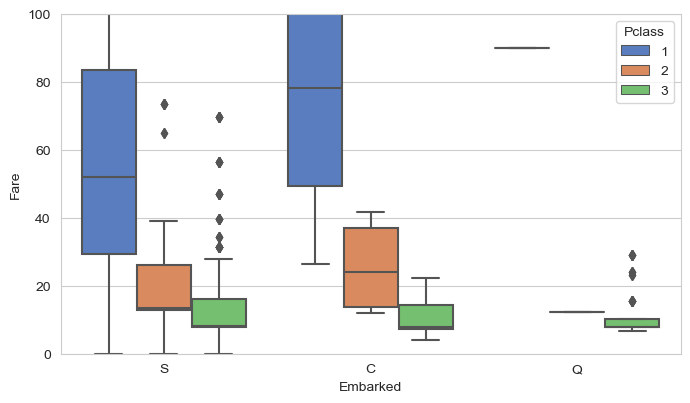

In [17]:
create_fig()
sns.boxplot(x='Embarked', y='Fare', data=df, hue='Pclass')
plt.ylim([0, 100])
plt.show()

> จะเห็นว่า Embarked = C ที่ class 1 มี med = 80 ใกล้เคียงกับค่าใน row ที่ missing มากกว่า (ถ้าเติมด้วย S, fare med = 50)

```py
df['Embarked'].fillna(df['Embarked'].value_counts().sort_values().index[2], inplace=True)
```

In [18]:
df['Embarked'].fillna('C', inplace=True)

In [19]:
df[df['PassengerId'].isin([62, 830])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,C
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,C


# 
## Count

`countplot` กับข้อมูลที่เป็น categorial / discrete

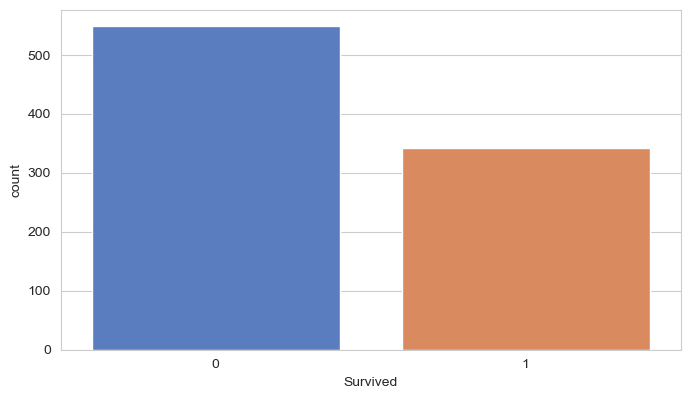

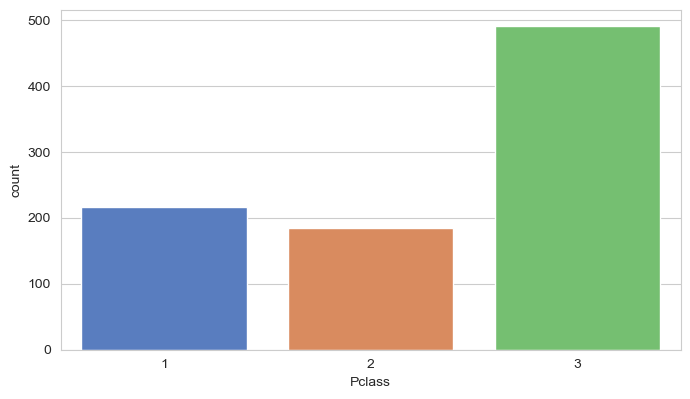

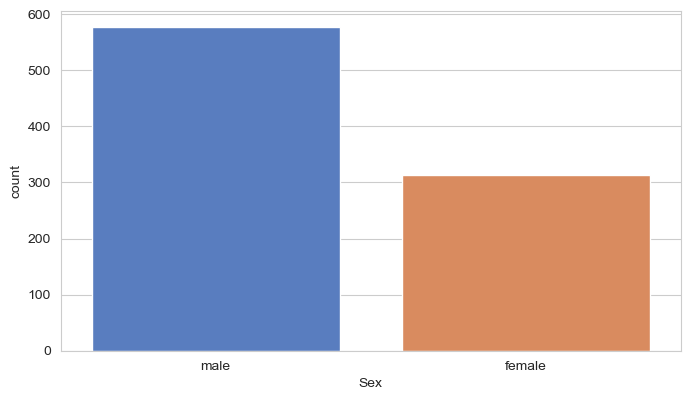

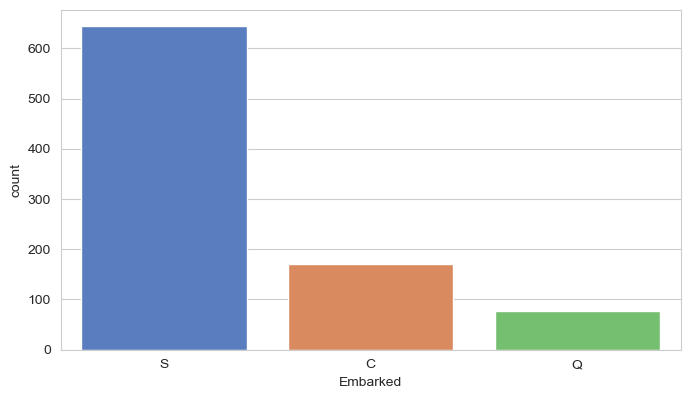

In [20]:
columns = ['Survived', 'Pclass', 'Sex', 'Embarked']
for col in columns:
    create_fig()
    sns.countplot(df[col])
    plt.show()

## countplot ระหว่าง variable

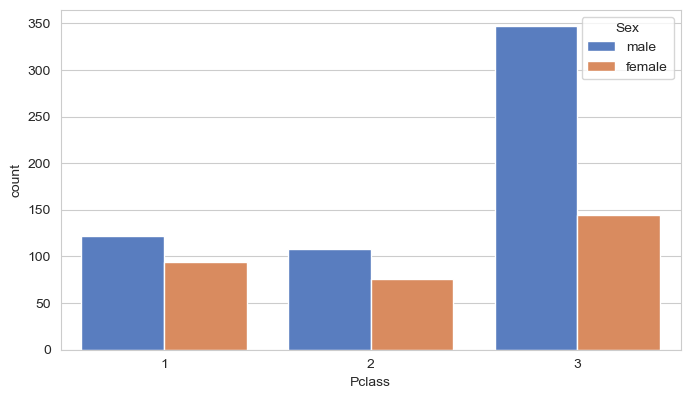

In [21]:
create_fig()
sns.countplot(x='Pclass', data=df, hue='Sex')

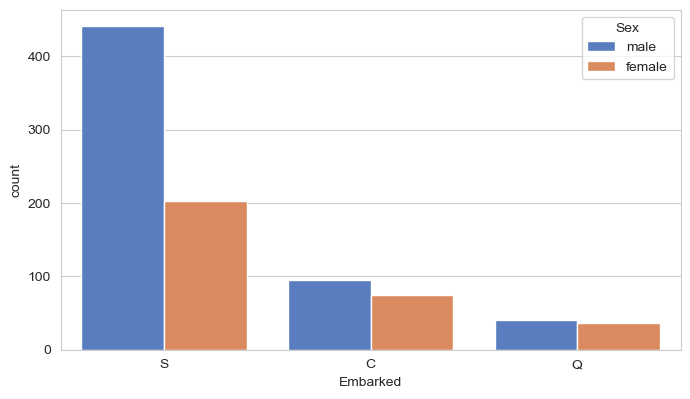

In [22]:
create_fig()
sns.countplot(x='Embarked', data=df, hue='Sex')

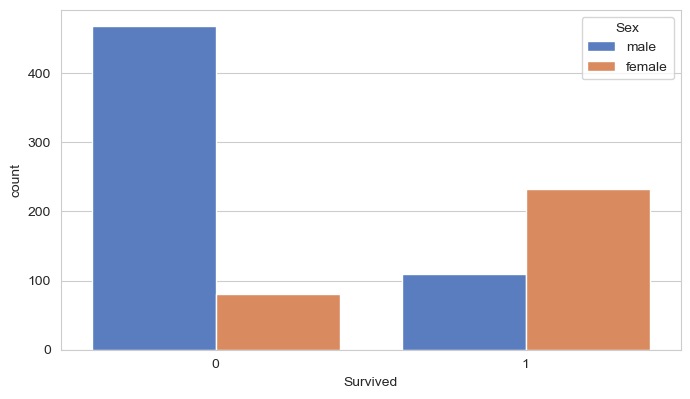

In [23]:
create_fig()
sns.countplot(x='Survived', data=df, hue='Sex')

> ผู้หญิงรอดมากกว่าผู้ชาย

### Count ... vs Survived

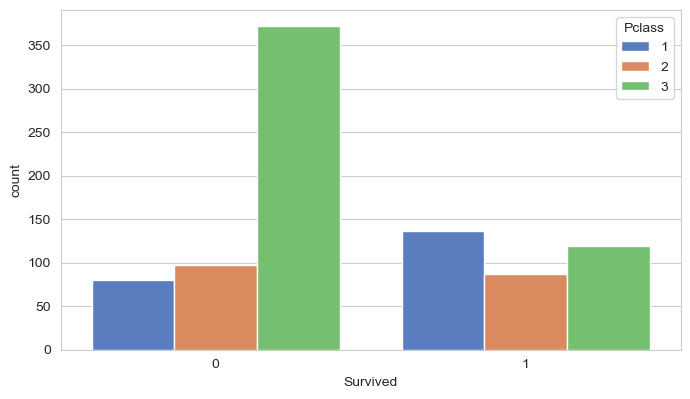

In [24]:
create_fig()
sns.countplot(x='Survived', data=df, hue='Pclass')

> 1st class มีโอกาสรอดมากกว่า 3rd class

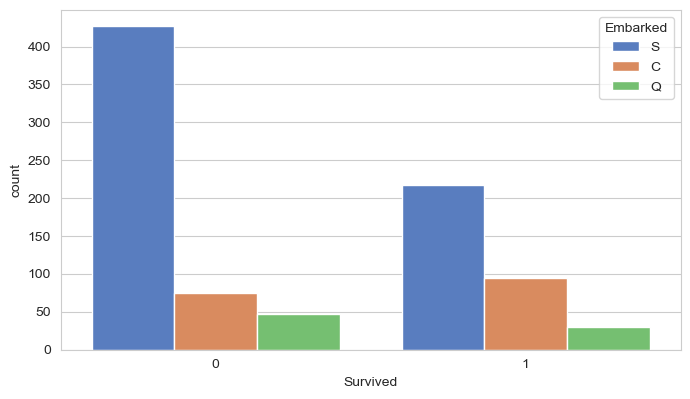

In [25]:
create_fig()
sns.countplot(x='Survived', data=df, hue='Embarked')

### สรุป จาก countplot
- ผญ มีโอกาสรอดมากกว่า ผช
- class 1 มีโอกาสรอดสูงกว่า class 3
- Embarked สถานที่ลงเรือไม่เกี่ยวกับโอกาสรอด

## Box plot

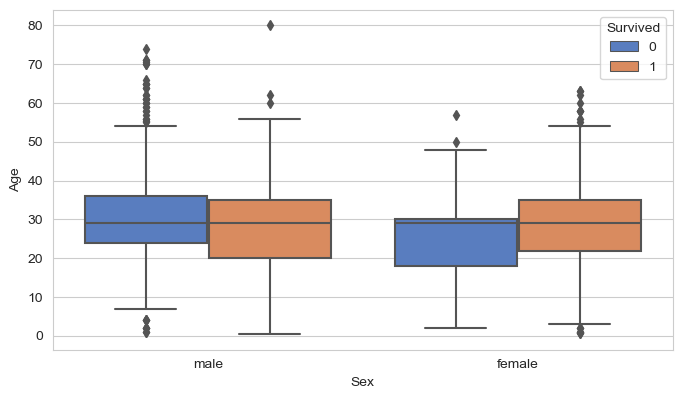

In [26]:
create_fig()
sns.boxplot(x='Sex', y='Age', data=df, hue="Survived")

> อายุเฉลี่ยของคนรอด มากกว่า คนไม่รอด

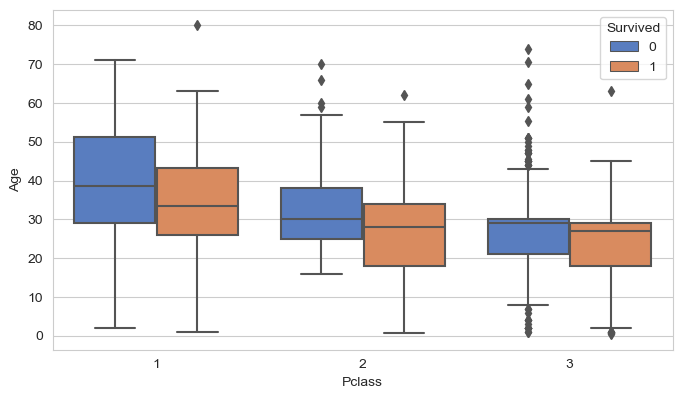

In [27]:
create_fig()
sns.boxplot(x='Pclass', y='Age', data=df, hue="Survived")

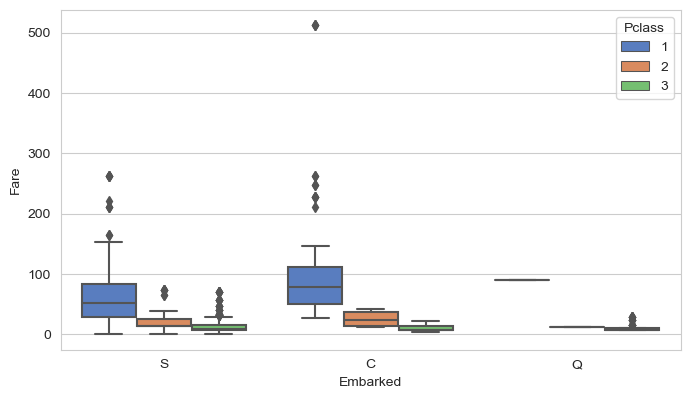

In [28]:
create_fig()
sns.boxplot(x='Embarked', y='Fare', data=df, hue="Pclass")

## Survived KDE

... distribution - Suvived vs not Survived

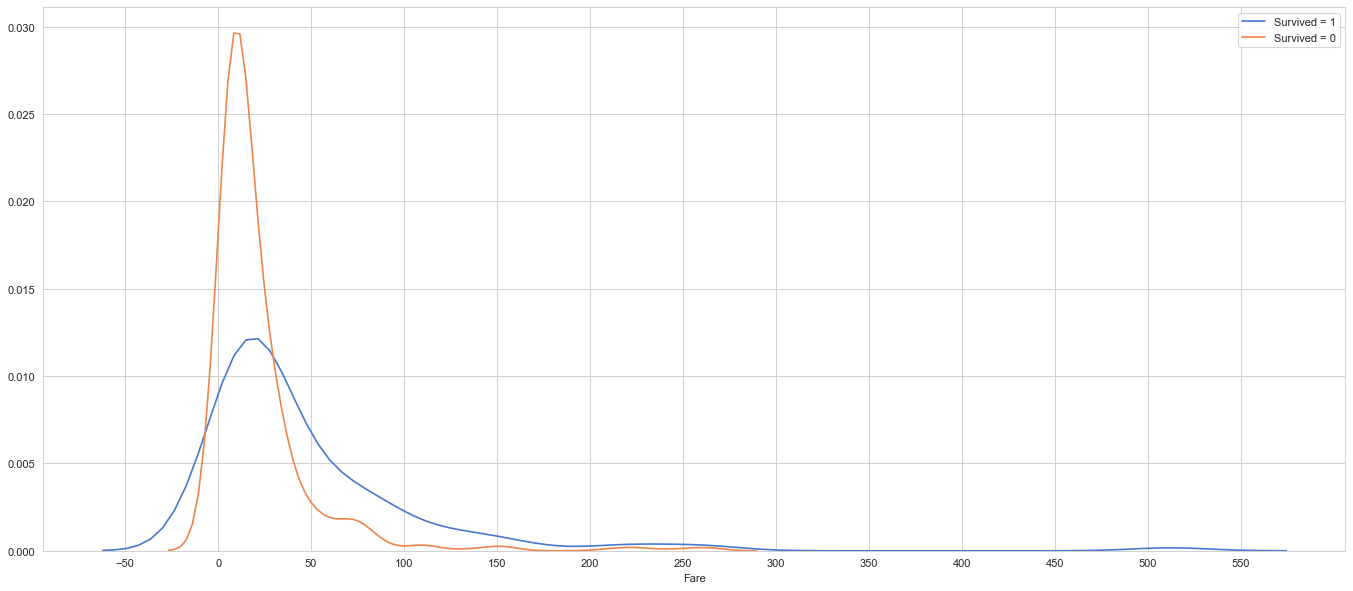

In [29]:
create_fig(figsize=(21, 9), dpi=80)
df_variable = 'Fare'
sns.kdeplot(df[df['Survived'] == 1][df_variable], label='Survived = 1')
sns.kdeplot(df[df['Survived'] == 0][df_variable], label='Survived = 0')
plt.xlabel(df_variable)
plt.xticks(np.arange(-50, 600, 50))
plt.show()

จาก [ML workflow](https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic/notebook)
- ถ้าสังเกตส่วนที่น้อยกว่า 100 \$
    - คนซื้อตั๋วราคาถูกเยอะมาก
    - และเส้นสีส้ม (ตาย) พุ่งสูงในตั๋วราคาถูก
- ช่วง 300-500 โอกาสเป็น 0
    - แปลกๆ ทำไมมีคนซื้อตั๋ว 550 \$ ? -> outlier

In [30]:
df[df['Fare'] > 300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


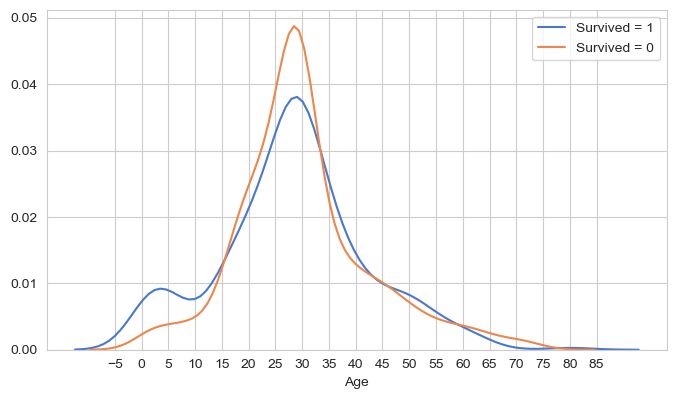

In [31]:
create_fig()
df_variable = 'Age'
sns.kdeplot(df[df['Survived'] == 1][df_variable], label='Survived = 1')
sns.kdeplot(df[df['Survived'] == 0][df_variable], label='Survived = 0')
plt.xlabel(df_variable)
plt.xticks(np.arange(-5, 90, 5))
plt.show()

> 0-5 y มีโอกาสรอดสูงกว่าตาย -> priority ให้เด็ก

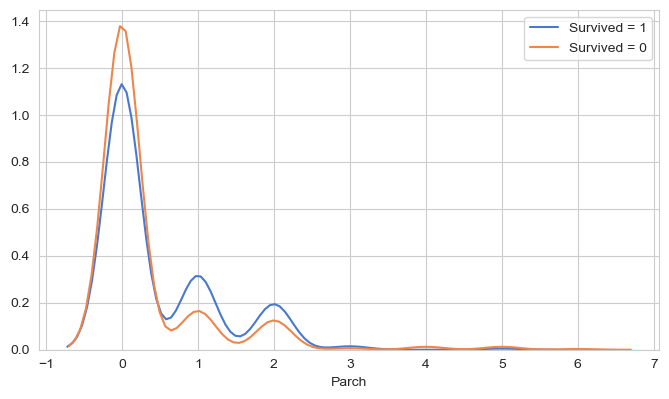

In [32]:
create_fig()
df_variable = 'Parch'
sns.kdeplot(df[df['Survived'] == 1][df_variable], label='Survived = 1')
sns.kdeplot(df[df['Survived'] == 0][df_variable], label='Survived = 0')
plt.xlabel(df_variable)
plt.show()

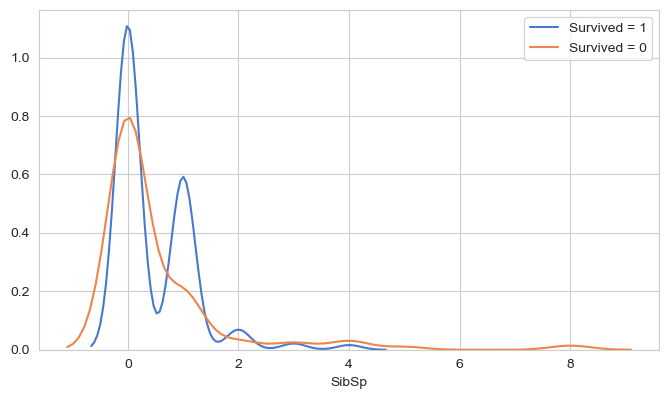

In [33]:
create_fig()
df_variable = 'SibSp'
sns.kdeplot(df[df['Survived'] == 1][df_variable], label='Survived = 1')
sns.kdeplot(df[df['Survived'] == 0][df_variable], label='Survived = 0')
plt.xlabel(df_variable)
plt.show()

> จาก KDE Parch/SibSp vs Survived จะเห็นว่ากลุ่มใหญ่ๆ โอกาสไม่รอดสูง

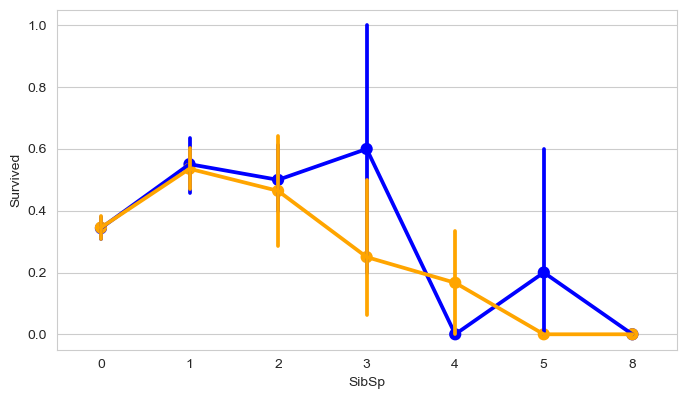

In [34]:
create_fig()
sns.pointplot(x='Parch', y='Survived', data=df, color='blue')
sns.pointplot(x='SibSp', y='Survived', data=df, color='orange')

# 
# Correlation

In [35]:
corr_df = df[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Survived']].corr()

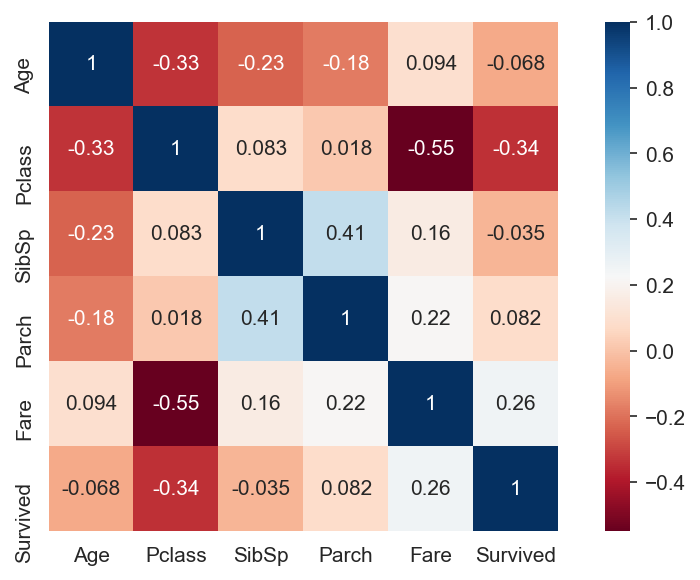

In [36]:
create_fig(dpi=150)
sns.heatmap(corr_df, annot=True, square=True, cmap='RdBu')

# 
## Pairplot

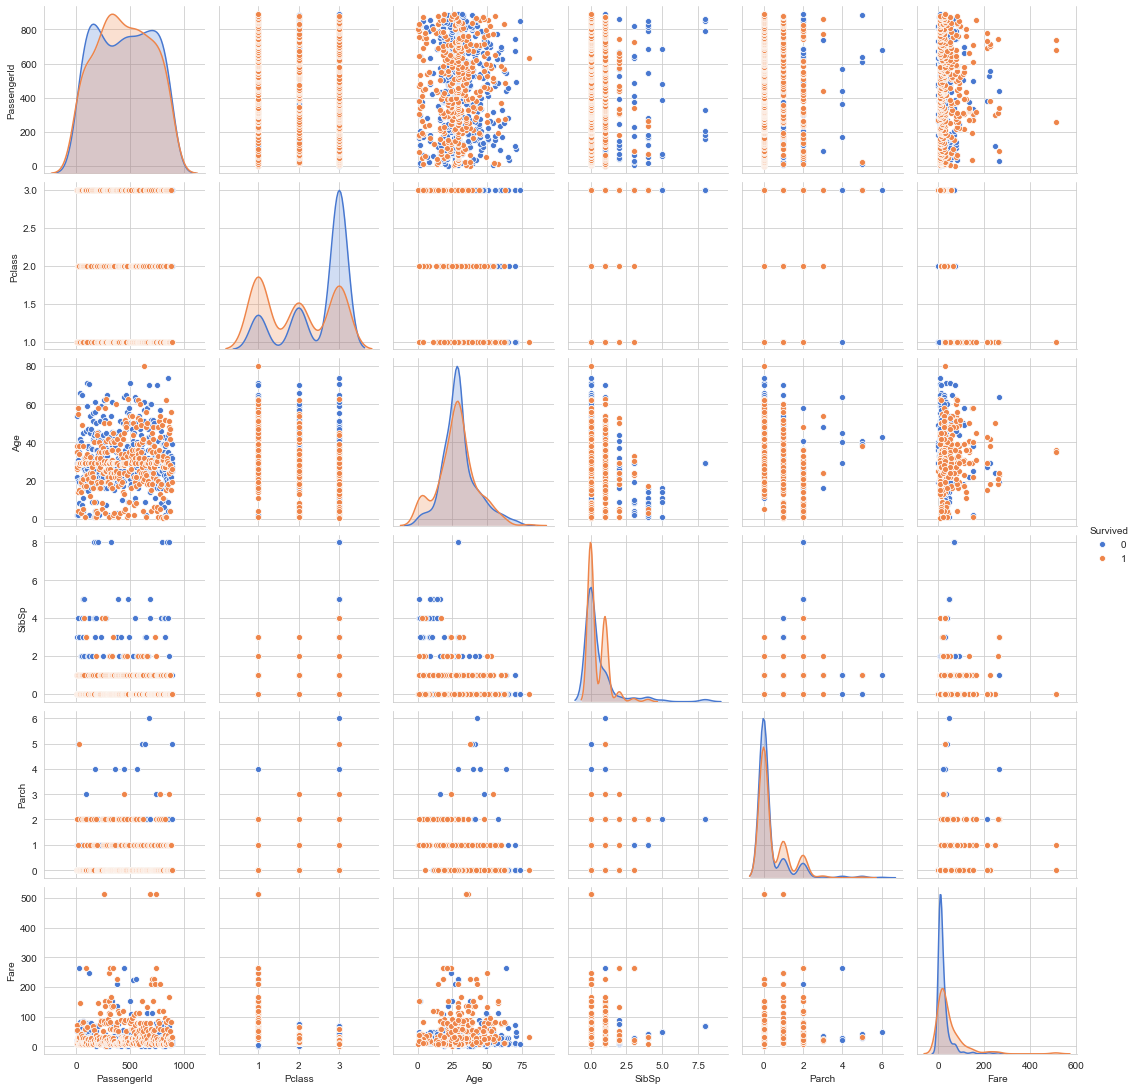

In [37]:
sns.pairplot(df, hue='Survived')

# 
## Statistic Testing by Scipy.stats
[t-test toward data sci](https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f)

## Fare vs Survived
- mu_fare_surv vs mu_fare_notsurv ??
    - H0: `mu1 == mu2`
    - Ha: `mu1 != mu2`

In [38]:
df_var = 'Fare'
surv = df[df['Survived'] == 1][df_var]
notsurv = df[df['Survived'] == 0][df_var]

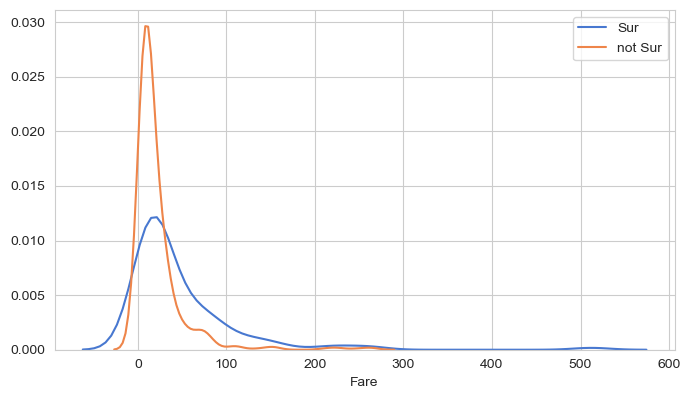

In [39]:
create_fig()
sns.distplot(surv, hist=False, label='Sur')
sns.distplot(notsurv, hist=False, label='not Sur')

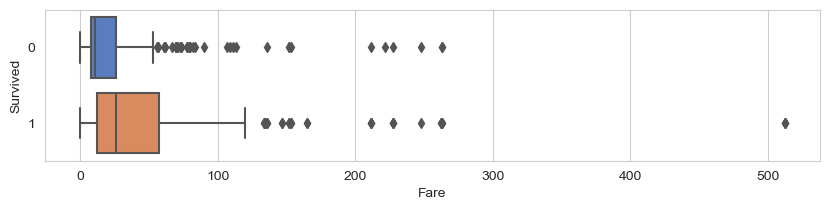

In [40]:
create_fig(figsize=(10, 2))
sns.boxplot(x=df_var, y='Survived', data=df, orient='h')

In [41]:
stats.ttest_ind(surv, notsurv)

Ttest_indResult(statistic=7.939191660871055, pvalue=6.120189341924198e-15)

### สรุป

> p-val < threshold (0.01, 0.05) >>> reject H0


> t-stat > crititcal t-val >>> มี stat. sig. difference ใน 2 pop


mean fare คนรอด ไม่เท่ากับ mean fare คนตาย

## Age vs Survived

In [42]:
df_var = 'Age'
surv = df[df['Survived'] == 1][df_var]
notsurv = df[df['Survived'] == 0][df_var]

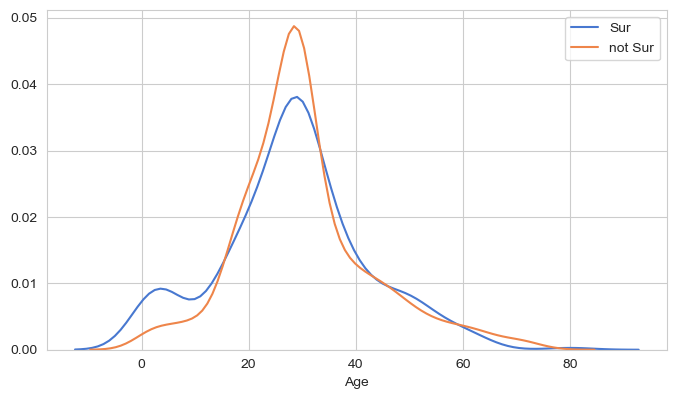

In [43]:
create_fig()
sns.distplot(surv, hist=False, label='Sur')
sns.distplot(notsurv, hist=False, label='not Sur')

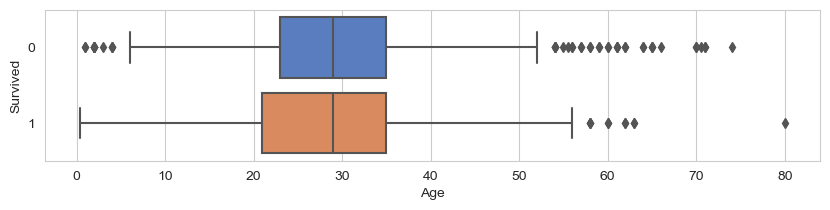

In [44]:
create_fig(figsize=(10, 2))
sns.boxplot(x=df_var, y='Survived', data=df, orient='h')

In [45]:
stats.ttest_ind(surv, notsurv)

Ttest_indResult(statistic=-2.026609929409089, pvalue=0.04300040105433479)

### สรุป

> p-val < threshold (0.05) >>> reject H0

ต่างใน thres 5% , ไม่ต่างใน thres 1%